In [4]:
# coding=utf-8
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae
from Helpers.helpers import set_rank, kendall_w

# Predefined variables

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)

rankings = ['THE', 'QS', 'CWUR', 'ARWU']
countries = {
    'AG': 'Argentina', 'AU': 'Austria', 'AUS': 'Australia', 'BE': 'Belgium', 'BEL': 'Belarus', 'BZ': 'Brazil',
    'CA': 'Canada', 'CH': 'China', 'CHI': 'Chile', 'COL': 'Colombia', 'CZ': 'Czech', 'DN': 'Denmark',
    'EG': 'Egypt', 'ES': 'Estonia', 'FI': 'Finland', 'FR': 'France', 'GE': 'Germany', 'GR': 'Greece',
    'IN': 'India', 'ID': 'Indonesia', 'IR': 'Ireland', 'IRN': 'Iran', 'IT': 'Italy', 'IS': 'Izrael',
    'JP': 'Japan', 'KO': 'Korea', 'KZ': 'Kazakhstan', 'LE': 'Lebanon', 'MA': 'Malaysia', 'ME': 'Mexico',
    'NE': 'Netherlands', 'NO': 'Norway', 'NZ': 'New Zealand', 'PH': 'Philippines', 'PAK': 'Pakistan',
    'POL': 'Poland', 'POR': 'Portugal', 'RU': 'Russia', 'SA': 'South Africa', 'SAU': 'Saudi Arabia',
    'SG': 'Singapore', 'SP': 'Spain', 'SW': 'Sweden', 'TH': 'Thailand', 'UA': 'Ukraine',
    'UAE': 'United Arab Emirates', 'UK': 'United Kingdom', 'US': 'United States of America'
}

media_dir = 'Media/'
EDA_dir = 'Media/EDA/'
rankings_dir = 'Media/Rankings'

inputs_all = list(map(str, list(range(1, 57))))
inputs_all.remove('47')

edu = list(map(str, list(range(1, 10))))
science = list(map(str, list(range(10, 21))))
staff = list(map(str, list(range(21, 30))))
inter = list(map(str, list(range(30, 39))))
infra = list(map(str, list(range(39, 47))))
fin = list(map(str, list(range(48, 57))))


inputs = ['1.1', '1', '9', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7', '2.16', '13', '14', '3.1', '3.2', 
          '3.8', '3.9', '35', '4.1', '4.3', '48', '5.1', '5.6', '40', '41', '42', '46', '6.1', '6.2', '6.4', '28',
         '2.1_2_3', '2.4_5_6', '3.1_2', '6.1_2', '13_14', '40_41_42']
inputs_grouped = ['1.1', '1', '9', '2.7', '2.16', '3.8', '3.9', '35', '4.1', '4.3', '48',
            '5.1', '5.6', '46', '6.4', '28', '2.1_2_3', '2.4_5_6', '3.1_2', '6.1_2', '13_14', '40_41_42']
outputs = ['E.1', 'E.2', 'E.3', 'E.4', 'E.5']

# Rankings

In [46]:
world = (pd.read_excel('Data/All_Universities_2020.xlsx')).iloc[:500, :29]
uni = world.University
world = world.set_index('University')
world.dropna(inplace = True)

world['Country'] = [countries[code] for code in world.loc[:, 'Country Code']]

# Fill ranged ranks (101-150, 800-1000)
for ranking in rankings:
    for rank_i in range(len(world[ranking])):
        rank = world[ranking][rank_i]
        if isinstance(rank, str):
            world.loc[:, ranking][rank_i] = set_rank(rank)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [47]:
# Convert to ranks
rdata = (world.reset_index())[rankings].rank(axis = 0, ascending = True)
rdata['University'] = uni
rdata = rdata.set_index('University')

world.THE = rdata.THE
world.QS = rdata.QS
world.CWUR = rdata.CWUR
world.ARWU = rdata.ARWU
rdata.head()

,THE,QS,CWUR,ARWU
University,,,,
Massachusetts Institute of Technology (MIT),5.0,1.0,2.0,4.0
Stanford University,4.0,2.0,3.0,2.0
Harvard University,7.0,3.0,1.0,1.0
University of Oxford,1.0,4.0,5.0,6.0
California Institute of Technology (Caltech),2.0,5.0,11.0,8.0


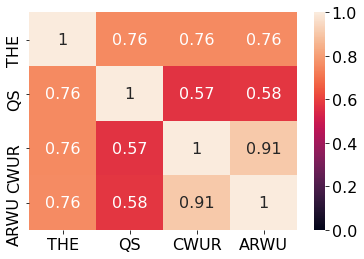

In [53]:
# All data
corr_matrix = scipy.stats.spearmanr(rdata.loc[:, rankings])[0]
sns.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True, xticklabels = rankings, yticklabels = rankings)
plt.savefig(media_dir + 'spearman_corr.png', bbox_inches='tight')

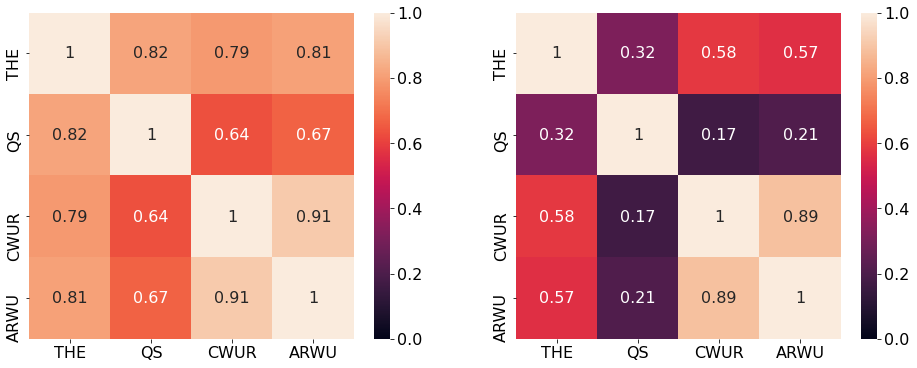

In [52]:
# 1-100 and 101-200
f, axes = plt.subplots(1, 2, figsize = (16, 6))
corr_matrix_100 = scipy.stats.spearmanr(rdata.loc[:, rankings][1:100])[0]
corr_matrix_200 = scipy.stats.spearmanr(rdata.loc[:, rankings][101:200])[0]

# sns.set(font_scale=1.4)
sns.heatmap(corr_matrix_100, vmin = 0, vmax = 1, annot = True, ax = axes[0], xticklabels = rankings, yticklabels = rankings)
sns.heatmap(corr_matrix_200, vmin = 0, vmax = 1, annot = True, ax = axes[1], xticklabels = rankings, yticklabels = rankings)
plt.savefig(media_dir + 'spearman_corr_1-100-200.png', bbox_inches='tight')

# Exploratory Data Analysis

In [54]:
rusuni = pd.read_excel('Data/Russian_Universities.xlsx')
rusuni.dropna(inplace = True)
rusuni.reset_index(drop = True, inplace = True)
rusuni = rusuni.loc[:, inputs + outputs + rankings + ['University', 'Region']]
rusuni.head()

,1.1,1,9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,...,E.2,E.3,E.4,E.5,THE,QS,CWUR,ARWU,University,Region
0,89.78,34838,1113,2064.72,2047.45,1577.35,85.12,95.16,143.13,8199628.1,...,979.35,7.50,3637.88,201.07,189.0,84.0,222.0,87.0,MSU,Moscow
1,97.52,6483,97,7135.52,7761.50,4917.96,217.13,247.86,334.41,3819955.2,...,4061.84,11.00,8767.60,244.94,237.0,302.0,539.0,473.0,MIPT,Moscow
2,95.76,28755,93,590.73,669.77,560.67,75.46,86.43,166.65,3718895.7,...,1461.66,9.56,8169.24,250.37,290.0,322.0,879.0,916.0,HSE,Moscow
3,92.28,5586,218,3203.41,3610.08,2046.36,279.07,348.53,273.33,2056242.8,...,3187.97,21.83,9751.86,282.76,482.0,329.0,726.0,643.0,MEPHI,Moscow
4,92.30,19277,2000,1484.47,1741.12,2178.31,84.13,99.73,174.48,2443650.9,...,603.40,13.87,4236.28,194.32,764.0,234.0,560.0,339.0,SPBU,StPetersburg


### Heatmaps

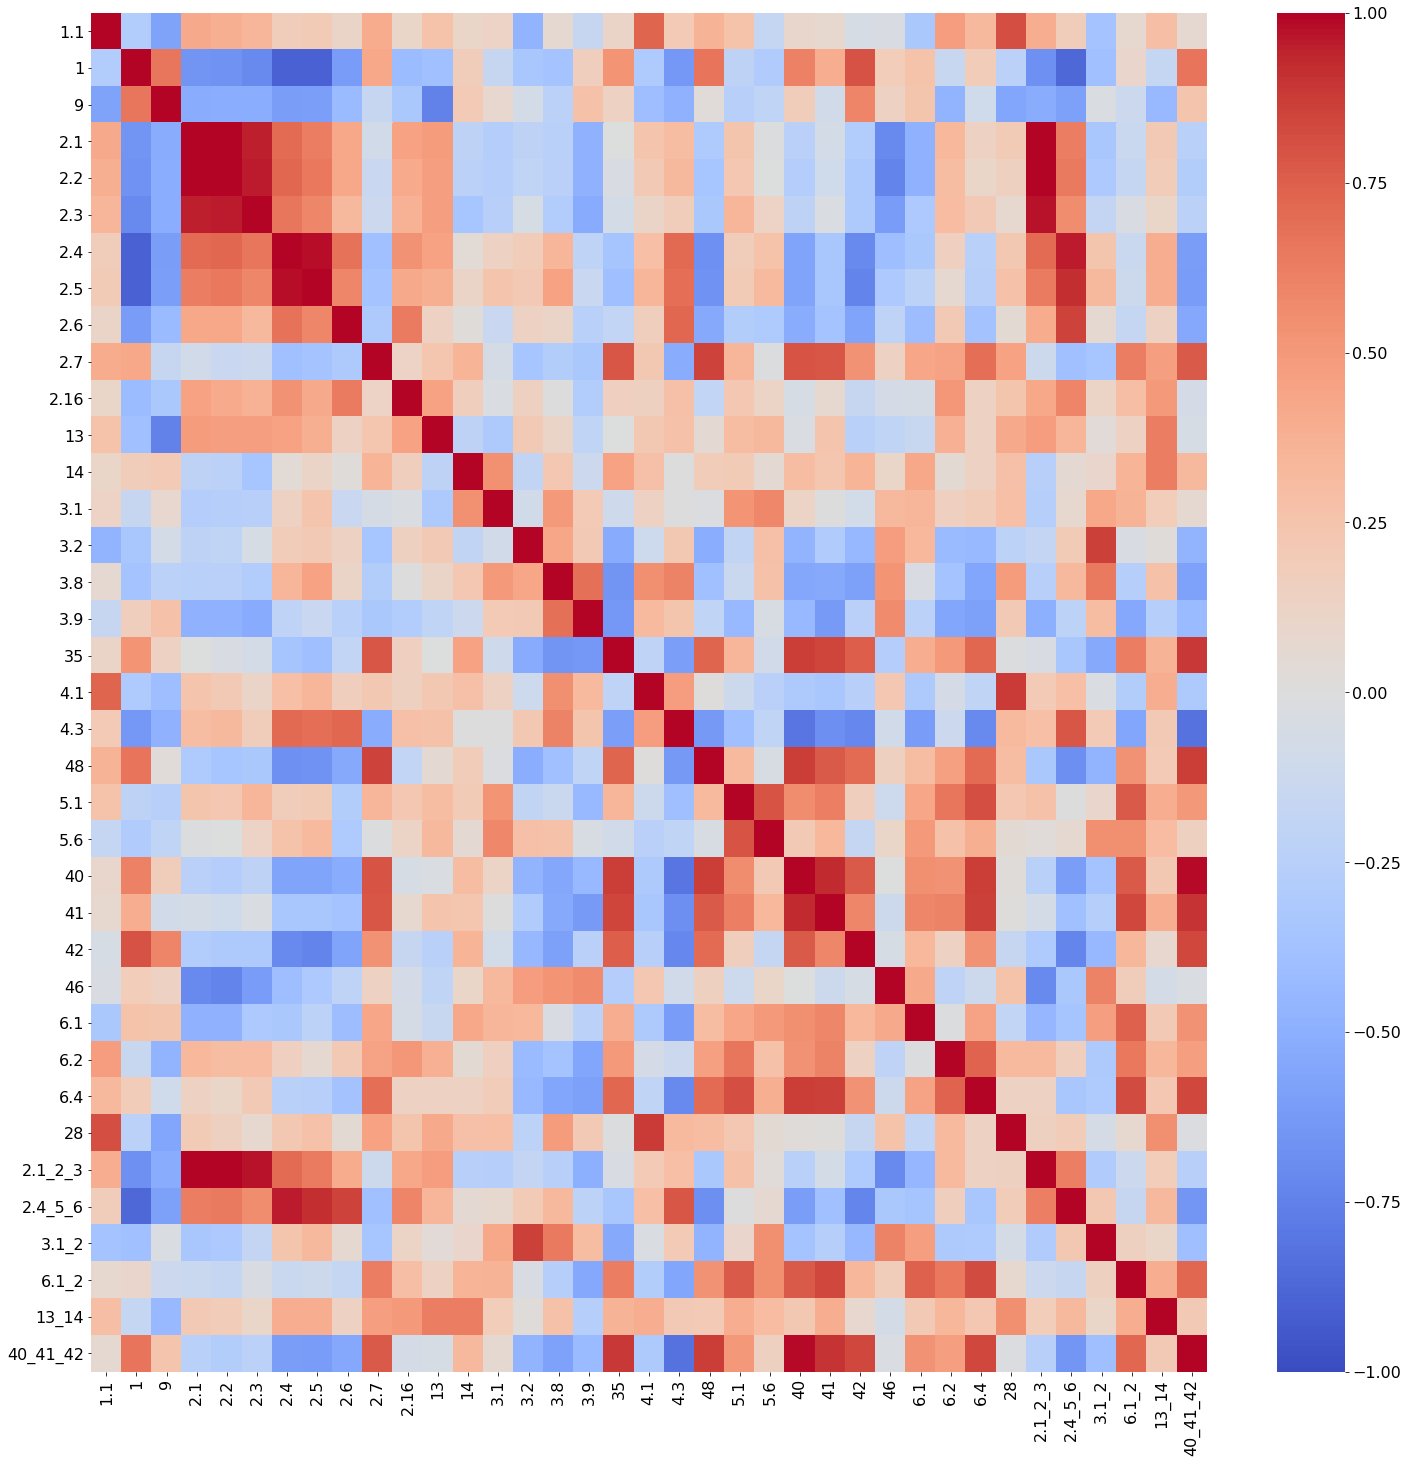

In [16]:
corr = rusuni.loc[:, inputs].corr()
plt.figure(figsize = (25, 25))
sns.heatmap(corr, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_inputs.png', bbox_inches='tight')

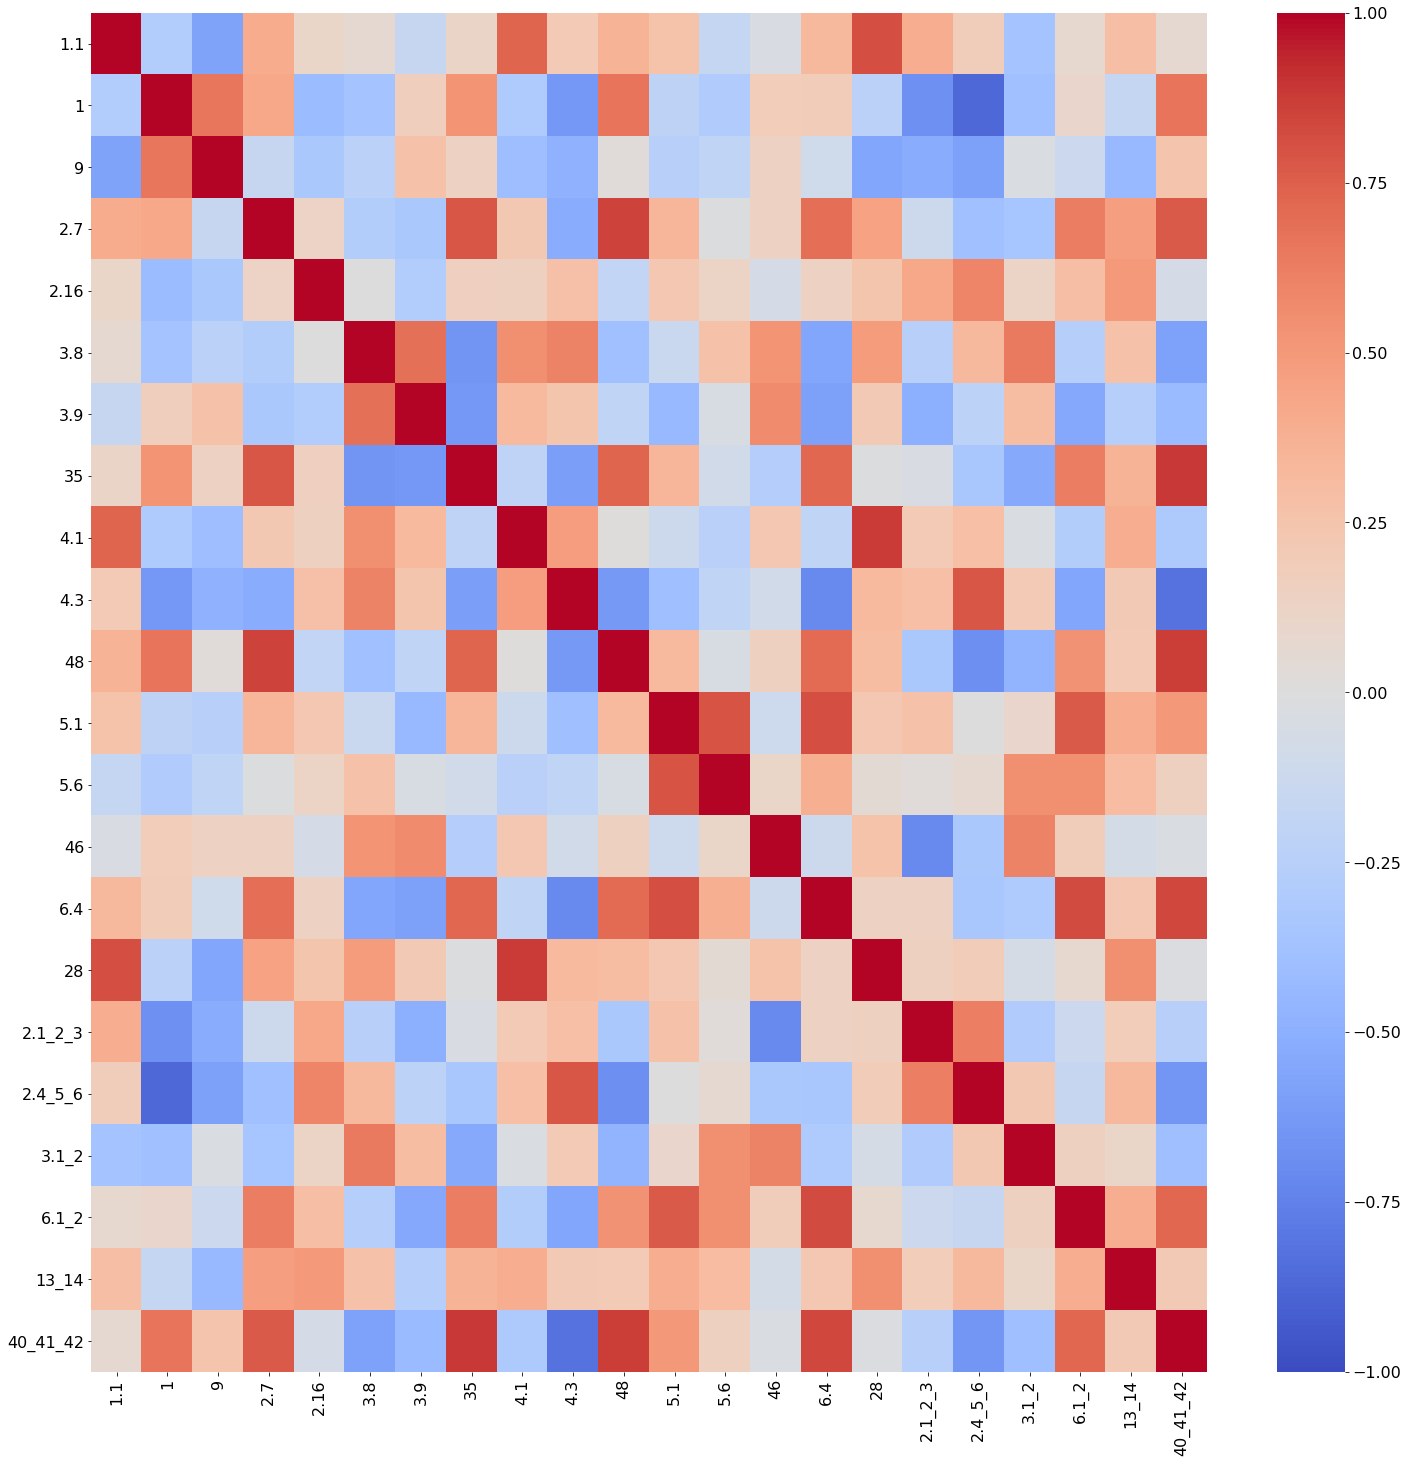

In [17]:
corr = rusuni.loc[:, inputs_grouped].corr()
plt.figure(figsize = (25, 25))
sns.heatmap(corr, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_inputs_grouped.png', bbox_inches='tight')

Number of variables: -8


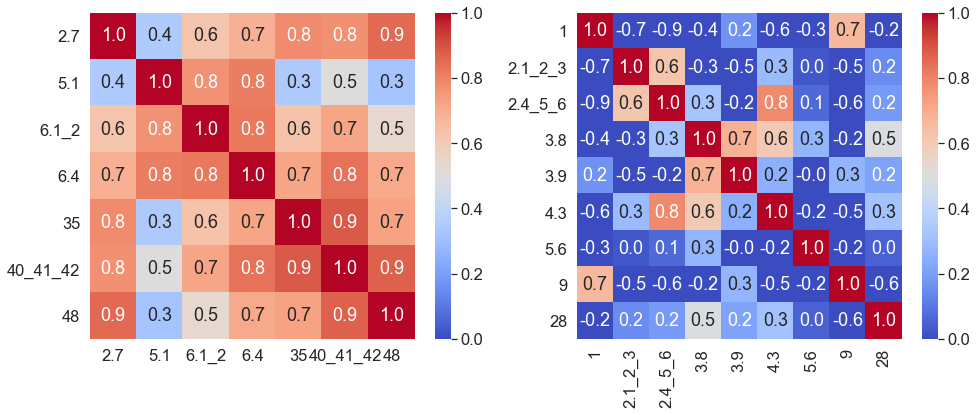

In [90]:
# Data exploration before PCA
f, axes = plt.subplots(1, 2, figsize = (16, 6))
positive_cor = ['2.7', '5.1', '6.1_2', '6.4', '35', '40_41_42', '48']
negative_cor = ['1', '2.1_2_3', '2.4_5_6', '3.8', '3.9', '4.3', '5.6', '9', '28']
output_cor_shrink = ['E.1', 'E.2', 'E.4', 'E.5']
output_cor = ['E.1', 'E.2', 'E.3', 'E.4', 'E.5']

corr_matrix_positive = rusuni.loc[:, positive_cor].corr()
corr_matrix_negative = rusuni.loc[:, negative_cor].corr()

sns.heatmap(corr_matrix_positive, vmin = 0, vmax = 1, annot = True, ax = axes[0], cmap = 'coolwarm', fmt=".1f")
sns.heatmap(corr_matrix_negative, vmin = 0, vmax = 1, annot = True, ax = axes[1], cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'spearman_corr_strong_weak.png', bbox_inches='tight')

print('Number of variables:', len(corr) - len(positive_cor) - len(negative_cor) + 3)

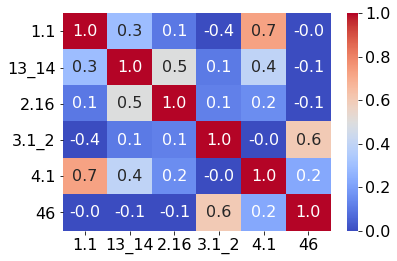

In [13]:
corr = ['1.1', '13_14', '2.16', '3.1_2', '4.1', '46']
corr_matrix = rusuni.loc[:, corr].corr()
sns.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True, cmap = 'coolwarm', fmt=".1f")

In [14]:
set(inputs_grouped) - set(positive_cor) - set(negative_cor)

{'1.1', '13_14', '2.16', '3.1_2', '4.1', '46'}

In [21]:
from sklearn.decomposition import PCA

pca_pos = PCA(n_components = 2)
pca_pos.fit(rusuni.loc[:, positive_cor].T)
PC1 = np.round(pca_pos.components_[0], 4)
# print('Explained variance ration positive: ', pca_pos.explained_variance_ratio_)
print('PC1 explained:', pca_pos.explained_variance_ratio_[0])


pca_neg = PCA(n_components = 2)
pca_neg.fit(rusuni.loc[:, negative_cor].T)
PC2 = np.round(pca_neg.components_[0], 4)
PC3 = np.round(pca_neg.components_[1], 4)
# print('Explained variance ration negative: ', pca_neg.explained_variance_ratio_)
print('PC2, PC3 explained:', pca_neg.explained_variance_ratio_[0:2])


pca_out = PCA(n_components = 2)
pca_out.fit(rusuni.loc[:, output_cor].T)
PC4 = np.round(pca_out.components_[0], 4)
# print('Explained variance ration negative: ', pca_neg.explained_variance_ratio_)
print('PC4 explained:', pca_out.explained_variance_ratio_[0])

pca_out = PCA(n_components = 2)
pca_out.fit(rusuni.loc[:, output_cor_shrink].T)
PC5 = np.round(pca_out.components_[0], 4)
# print('Explained variance ration negative: ', pca_neg.explained_variance_ratio_)
print('PC5 explained:', pca_out.explained_variance_ratio_[0])

rusuni.loc[:, 'INPUT1'] = PC1
rusuni.loc[:, 'INPUT2'] = PC2
rusuni.loc[:, 'INPUT3'] = PC3
rusuni.loc[:, 'OUTPUT_FULL'] = PC4
rusuni.loc[:, 'OUTPUT_SHRINK'] = PC5


rusuni.to_csv('Data/Russian_Universities.csv', index = False)

PC1 explained: 0.9942792352798083
PC2, PC3 explained: [0.84836963 0.14888786]
PC4 explained: 0.9861778886810342
PC5 explained: 0.9849453042637332


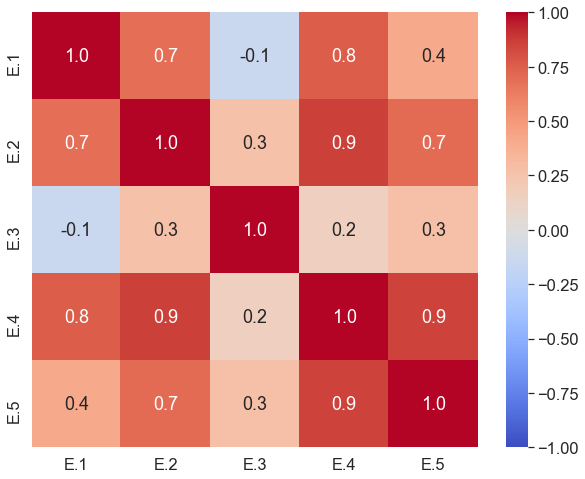

In [57]:
corr = rusuni.loc[:, outputs].corr()
plt.figure(figsize = (10, 8))
sns.set(font_scale=1.5)
sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_outputs.png', bbox_inches='tight')

### Distribution plots

In [223]:
for input in inputs:
    plt.figure(figsize = (20, 10))
    plt.plot(rusuni.University, rusuni[input])
    plt.title(input)
    plt.xticks(rotation = 90)
    plt.savefig(EDA_dir + 'Distributions/' + input + '.png', bbox_inches='tight')
    plt.close()

In [224]:
for output in outputs:
    plt.figure(figsize = (20, 10))
    plt.plot(rusuni.University, rusuni[output])
    plt.title(output)
    plt.xticks(rotation=90)
    plt.savefig(EDA_dir + 'Distributions/' + output + '.png', bbox_inches='tight')
    plt.close()

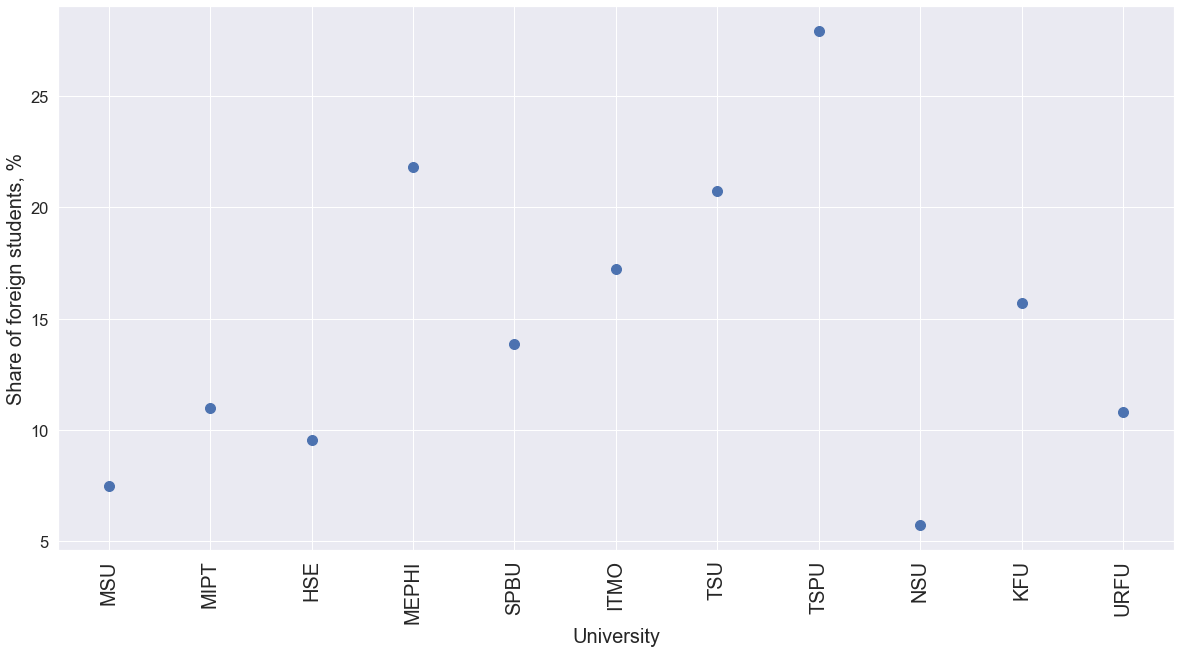

In [86]:
plt.figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['3.1_2'], 'o', markersize = 10)
plt.xlabel('University', fontsize = 20)
plt.ylabel('Share of foreign students, %', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.savefig(EDA_dir + '/3-1_2_explained.png', bbox_inches='tight')

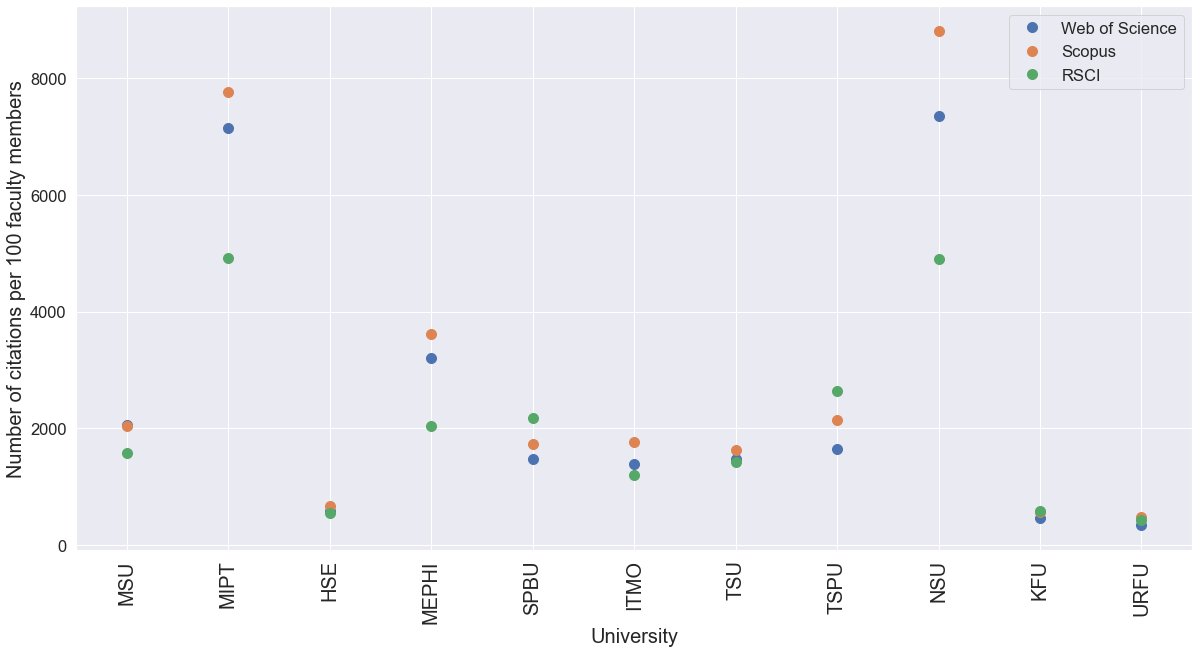

In [84]:
plt.figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['2.1'], 'o', markersize = 10)
plt.plot(rusuni.University, rusuni['2.2'], 'o', markersize = 10)
plt.plot(rusuni.University, rusuni['2.3'], 'o', markersize = 10)
plt.legend(['Web of Science', 'Scopus', 'RSCI'])
plt.xlabel('University', fontsize = 20)
plt.ylabel('Number of citations per 100 faculty members', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.savefig(EDA_dir + '/2-1_2_3_explained.png', bbox_inches='tight')

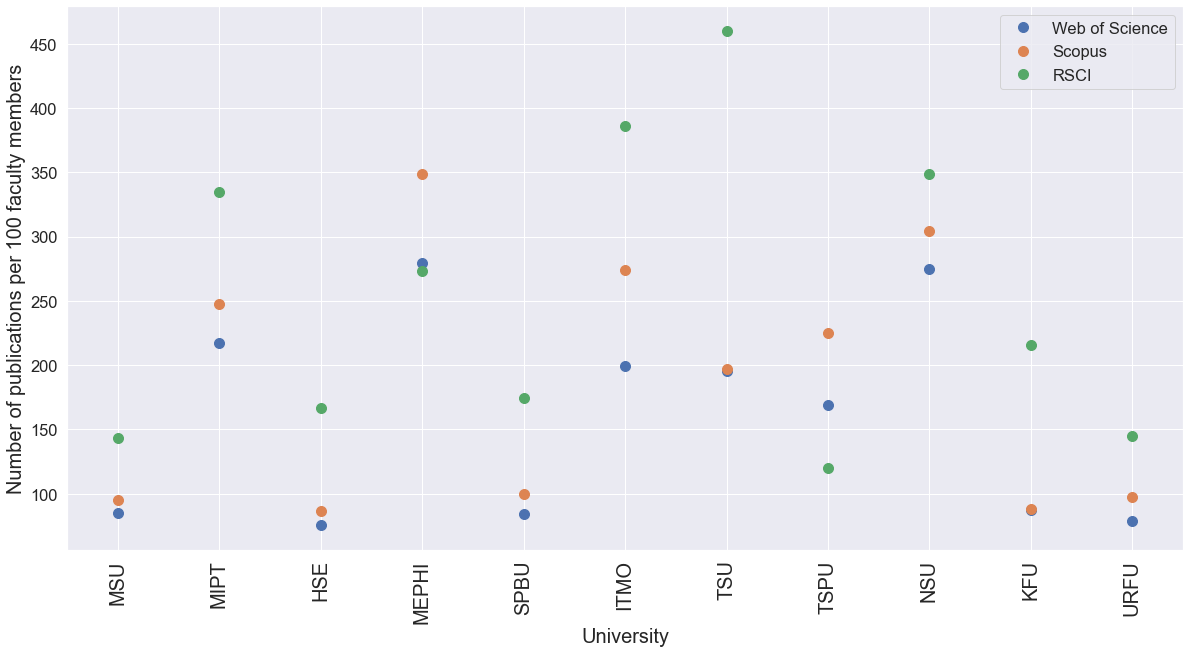

In [83]:
plt.figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['2.4'], 'o', markersize = 10)
plt.plot(rusuni.University, rusuni['2.5'], 'o', markersize = 10)
plt.plot(rusuni.University, rusuni['2.6'], 'o', markersize = 10)
plt.legend(['Web of Science', 'Scopus', 'RSCI'])
plt.xlabel('University', fontsize = 20)
plt.ylabel('Number of publications per 100 faculty members', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.savefig(EDA_dir + '/2-4_5_6_explained.png', bbox_inches='tight')

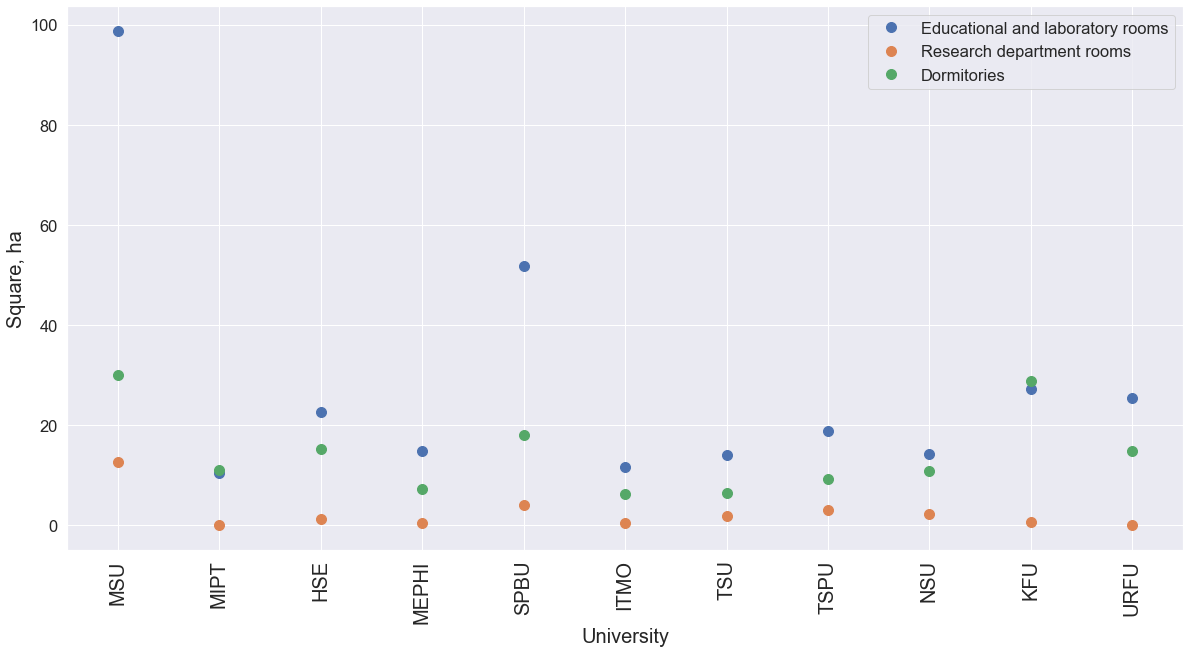

In [81]:
plt.figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['40'] / 10000, 'o', markersize = 10)
plt.plot(rusuni.University, rusuni['41'] / 10000, 'o', markersize = 10)
plt.plot(rusuni.University, rusuni['42'] / 10000, 'o', markersize = 10)
plt.legend(['Educational and laboratory rooms', 'Research department rooms', 'Dormitories'])
plt.xlabel('University', fontsize = 20)
plt.ylabel('Square, ha', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.savefig(EDA_dir + '/40_41_42_explained.png', bbox_inches='tight')

### Boxplots

In [317]:
for input in inputs:
    plt.figure(figsize = (20, 10))
    sns.boxplot(rusuni[input])
    plt.title(input)
    plt.xticks(rotation = 90)
    plt.savefig(EDA_dir + 'BoxPlots/' + input + '.png', bbox_inches='tight')
    plt.close()

In [318]:
for output in outputs:
    plt.figure(figsize = (20, 10))
    sns.boxplot(rusuni[output])
    plt.title(output)
    plt.xticks(rotation=90)
    plt.savefig(EDA_dir + '/BoxPlots/' + output + '.png', bbox_inches='tight')
    plt.close()

### Pairplots

In [ ]:
sns.pairplot(data.loc[:, inputs])

### Description

In [308]:
rusuni.groupby('Region').count().University
# rusuni.describe()

Region
Ekaterinburg    1
Kazan           1
Moscow          4
Novosibirsk     1
StPetersburg    2
Tomsk           2
Name: University, dtype: int64

### Universities time series

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


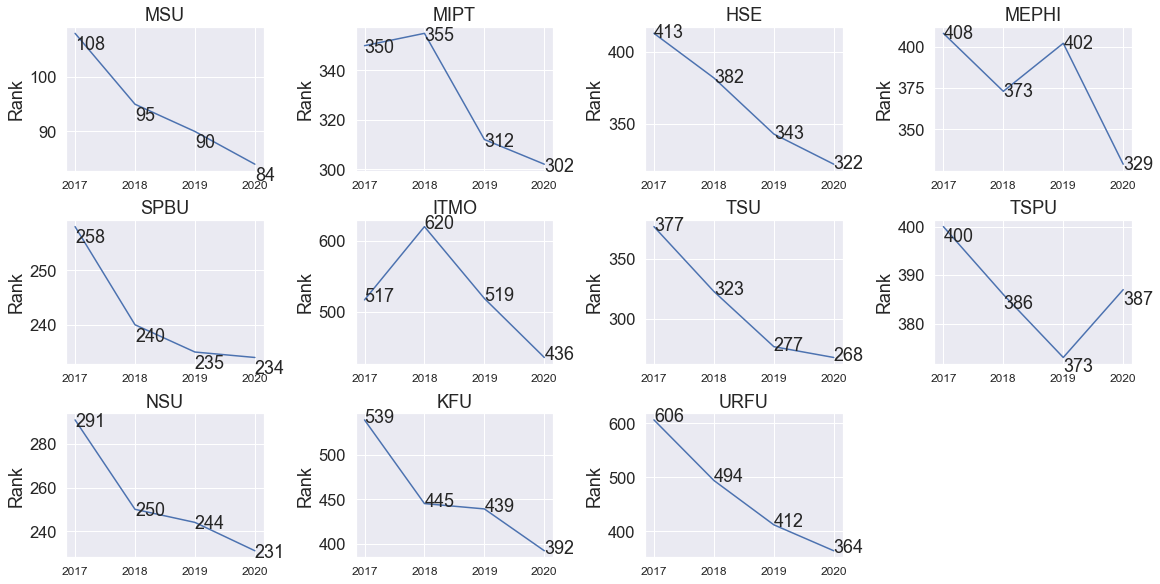

In [62]:
ts = pd.read_excel('Data/Russian_Universities_TS.xlsx')
QS = ts.loc[(ts.University.isin(rusuni.University)) & (ts.Ranking == 'QS')]
QS.dropna(inplace = True)

fig, axes = plt.subplots(3, 4, figsize = (16, 8), constrained_layout = True)

k = 0
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        if k < len(rusuni.University):
            uni_name = rusuni.University[k]
            u = QS.loc[QS.University == uni_name]
            u.reset_index(drop = True, inplace = True)
            axes[i, j].plot(u.Year, u.Rank)
            axes[i, j].set_xticks(u.Year)
            axes[i, j].set_xticklabels(u.Year, fontsize = 12)
            axes[i, j].set_title(uni_name)
            axes[i, j].set_ylabel('Rank')

            
            for ix, _ in enumerate(u.Year):
                axes[i, j].text(u.Year[ix], int(u.Rank[ix]) - 3, int(u.Rank[ix]))
        k = k + 1

axes[-1, -1].axis('off')
plt.savefig(media_dir + 'Russian_TS.png')

# Results

In [31]:
rusuni = pd.read_excel('Data/Russian_Universities.xlsx')
rusuni.dropna(inplace = True)
rusuni.reset_index(drop = True, inplace = True)
rusuni = rusuni.loc[:, inputs + outputs + rankings + ['University', 'Region']]
rusuni.head(15)

,1.1,1,9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,...,E.2,E.3,E.4,E.5,THE,QS,CWUR,ARWU,University,Region
0,89.78,34838,1113,2064.72,2047.45,1577.35,85.12,95.16,143.13,8199628.1,...,979.35,7.50,3637.88,201.07,189.0,84.0,222.0,87.0,MSU,Moscow
1,97.52,6483,97,7135.52,7761.50,4917.96,217.13,247.86,334.41,3819955.2,...,4061.84,11.00,8767.60,244.94,237.0,302.0,539.0,473.0,MIPT,Moscow
2,95.76,28755,93,590.73,669.77,560.67,75.46,86.43,166.65,3718895.7,...,1461.66,9.56,8169.24,250.37,290.0,322.0,879.0,916.0,HSE,Moscow
3,92.28,5586,218,3203.41,3610.08,2046.36,279.07,348.53,273.33,2056242.8,...,3187.97,21.83,9751.86,282.76,482.0,329.0,726.0,643.0,MEPHI,Moscow
4,92.30,19277,2000,1484.47,1741.12,2178.31,84.13,99.73,174.48,2443650.9,...,603.40,13.87,4236.28,194.32,764.0,234.0,560.0,339.0,SPBU,StPetersburg
5,90.58,12127,685,1398.87,1774.74,1206.60,199.55,274.33,386.08,2859225.2,...,3356.29,17.21,7706.76,247.55,459.0,436.0,1002.0,834.0,ITMO,StPetersburg
6,79.18,13578,343,1478.72,1630.92,1427.68,195.69,196.98,459.92,1838876.2,...,1694.19,20.74,5485.34,239.66,531.0,268.0,983.0,824.0,TSU,Tomsk
7,78.25,11720,1012,1642.09,2136.90,2645.27,169.28,224.69,119.80,1913427.6,...,1434.51,27.92,3969.73,218.50,715.0,387.0,1399.0,886.0,TSPU,Tomsk
8,87.01,7690,82,7351.08,8798.85,4906.22,274.90,304.29,349.06,583175.3,...,586.81,5.72,3773.55,230.52,585.0,231.0,610.0,471.0,NSU,Novosibirsk
9,80.03,32358,5058,474.83,574.83,596.12,87.17,87.91,215.69,1746168.2,...,615.50,15.71,3298.97,223.91,626.0,392.0,1090.0,853.0,KFU,Kazan


In [32]:
# number of universities in each ranking
THE_len = 1397
QS_len = 1002
CWUR_len = 2000
ARWU_len = 1000

rusuni['THE_eff'] = (THE_len - rusuni.THE) / THE_len
rusuni['QS_eff'] = (QS_len - rusuni.QS) / QS_len
rusuni['CWUR_eff'] = (CWUR_len - rusuni.CWUR) / CWUR_len
rusuni['ARWU_eff'] = (ARWU_len - rusuni.ARWU) / ARWU_len
rusuni['SFA_eff'] = [0.9934, 0.9934, 0.9961, 0.9975, 0.9958, 0.9858, 0.9946, 0.9941, 0.9953, 0.9933, 0.9965]

rusuni.head(11)

,1.1,1,9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,...,QS,CWUR,ARWU,University,Region,THE_eff,QS_eff,CWUR_eff,ARWU_eff,SFA_eff
0,89.78,34838,1113,2064.72,2047.45,1577.35,85.12,95.16,143.13,8199628.1,...,84.0,222.0,87.0,MSU,Moscow,0.864710,0.916168,0.8890,0.913,0.9934
1,97.52,6483,97,7135.52,7761.50,4917.96,217.13,247.86,334.41,3819955.2,...,302.0,539.0,473.0,MIPT,Moscow,0.830351,0.698603,0.7305,0.527,0.9934
2,95.76,28755,93,590.73,669.77,560.67,75.46,86.43,166.65,3718895.7,...,322.0,879.0,916.0,HSE,Moscow,0.792412,0.678643,0.5605,0.084,0.9961
3,92.28,5586,218,3203.41,3610.08,2046.36,279.07,348.53,273.33,2056242.8,...,329.0,726.0,643.0,MEPHI,Moscow,0.654975,0.671657,0.6370,0.357,0.9975
4,92.30,19277,2000,1484.47,1741.12,2178.31,84.13,99.73,174.48,2443650.9,...,234.0,560.0,339.0,SPBU,StPetersburg,0.453114,0.766467,0.7200,0.661,0.9958
5,90.58,12127,685,1398.87,1774.74,1206.60,199.55,274.33,386.08,2859225.2,...,436.0,1002.0,834.0,ITMO,StPetersburg,0.671439,0.564870,0.4990,0.166,0.9858
6,79.18,13578,343,1478.72,1630.92,1427.68,195.69,196.98,459.92,1838876.2,...,268.0,983.0,824.0,TSU,Tomsk,0.619900,0.732535,0.5085,0.176,0.9946
7,78.25,11720,1012,1642.09,2136.90,2645.27,169.28,224.69,119.80,1913427.6,...,387.0,1399.0,886.0,TSPU,Tomsk,0.488189,0.613772,0.3005,0.114,0.9941
8,87.01,7690,82,7351.08,8798.85,4906.22,274.90,304.29,349.06,583175.3,...,231.0,610.0,471.0,NSU,Novosibirsk,0.581246,0.769461,0.6950,0.529,0.9953
9,80.03,32358,5058,474.83,574.83,596.12,87.17,87.91,215.69,1746168.2,...,392.0,1090.0,853.0,KFU,Kazan,0.551897,0.608782,0.4550,0.147,0.9933


In [34]:
print('MAE THE:', mae(rusuni.SFA_eff, rusuni.THE_eff))
print('MAE QS:', mae(rusuni.SFA_eff, rusuni.QS_eff))
print('MAE ARWU:', mae(rusuni.SFA_eff, rusuni.ARWU_eff))
print('MAE CWUR:', mae(rusuni.SFA_eff, rusuni.CWUR_eff))

MAE THE: 0.3767366825014642
MAE QS: 0.2980104881146797
MAE ARWU: 0.6368000000000001
MAE CWUR: 0.41270909090909086
